In [14]:
import torch 
import requests
from torch import nn 
import matplotlib.pyplot as plt 
from torch.nn import functional as F 
from io import BytesIO
from tqdm.auto import tqdm 
from torchvision import transforms as tfms
from diffusers import StableDiffusionPipeline,DDIMScheduler
from PIL import Image

def load_image(url, size=None):
    response = requests.get(url,timeout=0.2)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    if size is not None:
        img = img.resize(size)
    return img

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
pipe = StableDiffusionPipeline.from_pretrained('runwayml/stable-diffusion-v1-5').to(device)

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

safety_checker%2Fconfig.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

scheduler%2Fscheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

text_encoder%2Fconfig.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer%2Fmerges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)ure_extractor%2Fpreprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer%2Fspecial_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

unet%2Fconfig.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer%2Fvocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer%2Ftokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vae%2Fconfig.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

  0%|          | 0/50 [00:00<?, ?it/s]

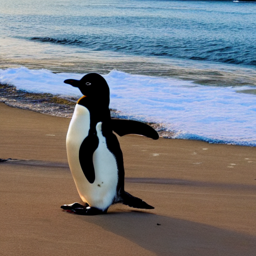

In [6]:
prompt = 'Beautiful DSLR Photograph of a penguin on the beach, golden hour'
negative_prompt = 'blurry, ugly, stock photo'

im = pipe(prompt,negative_prompt=negative_prompt).images[0]
im.resize((256,256))

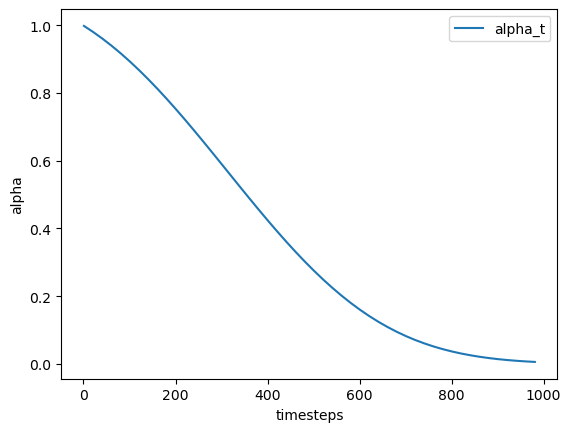

In [8]:
timesteps = pipe.scheduler.timesteps.cpu()
alphas = pipe.scheduler.alphas_cumprod[timesteps]
plt.plot(timesteps,alphas,label='alpha_t')
plt.xlabel('timesteps')
plt.ylabel('alpha')
plt.legend()
plt.show()

# DDIM Sampling 
<li>At a given time t, the noisy image  xt  is some mixture of the original image x0 and some noise ϵ 

$$ x_t = \sqrt{\alpha_t}x_0 + \sqrt{1-\alpha_t}\epsilon $$

<li> alpha is unit variance
<li> At t = 0, we begin with a clean image and no noise alpha = 1. As timesteps increases we end up with almost all noise and noise alpha drops to 0. 
<li> During sampling we begin with pure noise at t = 1000 and slowly move towards t=0.
<li>To calculate next t we predict the noise and use it to calculate the predicted denoised image  
<li> We use this prediction to move a small distance pointing to xt and we can add some additional noise scaled by sigma 

  0%|          | 0/50 [00:00<?, ?it/s]

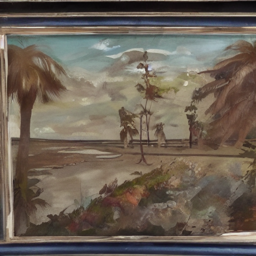

In [25]:
@torch.no_grad()
def sample(prompt, start_step=0, start_latents=None, 
           guidance_scale=3.5, num_inference_steps=30,
           num_images_per_prompt=1, do_classifier_free_guidance=True,
           negative_prompt='', device=device):

    # Encode prompt
    text_embeddings, _ = pipe.encode_prompt(
        prompt=prompt, device=device, num_images_per_prompt=num_images_per_prompt,
        do_classifier_free_guidance=do_classifier_free_guidance, negative_prompt=negative_prompt
    )
    text_embeddings = text_embeddings.to(pipe.unet.dtype)  # ✅ Ensure correct dtype

    # Set scheduler timesteps
    pipe.scheduler.set_timesteps(num_inference_steps, device=device)

    # Initialize latents
    if start_latents is None:
        start_latents = torch.randn((1, 4, 64, 64), device=device, dtype=pipe.unet.dtype)
        start_latents *= pipe.scheduler.init_noise_sigma
    
    latents = start_latents.clone()

    for i in tqdm(range(start_step, num_inference_steps)):
        t = pipe.scheduler.timesteps[i]

        # ✅ Ensure latents match the batch size of text_embeddings
        latent_model_input = latents.expand(text_embeddings.shape[0], -1, -1, -1)

        # Scale input latents
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        # Predict noise
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample 

        # ✅ FIX: Only apply CFG if batch size is 2
        if do_classifier_free_guidance and noise_pred.shape[0] == 2:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        
        # Scheduler step
        latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample 

    # Decode latents
    latents = latents / pipe.vae.config.scaling_factor
    with torch.no_grad():
        image = pipe.vae.decode(latents).sample 

    # Convert tensor to image
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    
    return pil_images

# Run the function
sample('Watercolor painting of a beach sunset', num_inference_steps=50)[0].resize((256, 256))


# Inversion 
<li> Goal of inversion is to reverse the sampling process we want to end up with a noisy latents which is used as the starting point for usual sampling procedure resulting in original image generated 


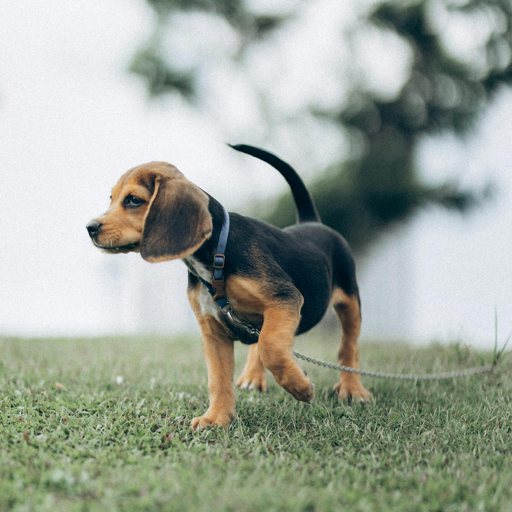

In [26]:
input_image = load_image('https://images.pexels.com/photos/8306128/pexels-photo-8306128.jpeg', size=(512, 512))
input_image

In [27]:
input_image_prompt = "Photograph of a puppy on the grass"

In [28]:
with torch.no_grad(): latent = pipe.vae.encode(tfms.functional.to_tensor(input_image).unsqueeze(0).to(device)*2-1)
l = 0.18215 * latent.latent_dist.sample()

In [ ]:
@torch.no_grad()
def invert(start_latents, prompt, guidance_scale=3.5, num_inference_steps=80,
           num_images_per_prompt=1, do_classifier_free_guidance=True,
           negative_prompt='', device=device):
    text_embeddings,_ = pipe.encode_prompt(prompt,device,num_images_per_prompt,
                                           do_classifier_free_guidance,negative_prompt)
    latents = start_latents.clone()
    intermediate_latents = []

    pipe.scheduler.set_timesteps(num_inference_steps,device=device)
    timesteps = reversed(pipe.scheduler.timesteps)

    for i in tqdm(range(1,num_inference_steps,total=num_inference_steps-1)):

        if i >= num_inference_steps - 1: 
            continue 

        t = timesteps[i]
        latent_model_input = torch.cat([latents]*2) if 
